In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from scipy.cluster.hierarchy import dendrogram

import re
import string
import time
from PIL import Image
from collections import Counter

import plotly.express as px

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words as nltk_words
from nltk.corpus import stopwords

nltk.download('stopwords', download_dir='../resources')
nltk.download('punkt', download_dir='../resources')
nltk.download('wordnet', download_dir='../resources')
nltk.download('omw-1.4', download_dir='../resources')
nltk.download('words', download_dir='../resources')

[nltk_data] Downloading package stopwords to ./resources...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./resources...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to ./resources...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ./resources...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to ./resources...
[nltk_data]   Package words is already up-to-date!


In [ ]:
nltk.data.path.append('../resources')

## Trends limits:
By default, it is set to 100 requests per 100 seconds per user and can be adjusted to a maximum value of 1,000. But the number of requests to the API is restricted to a maximum of 10 requests per second per user.

In [2]:
!ls && ls ./Data

Data                           infer_results.ipynb
README.md                      kmeans_online_clustering.ipynb
assets                         resources
combined_analysis.ipynb        titles_analysis.ipynb
descriptions_analysis.ipynb
bbc_news.csv                          description-dbscan-clusters.csv
bbc_news_new.csv                      description-kmeans-clusters.csv
combined-agg-complete-clusters.csv    description-optics-clusters.csv
combined-agg-ward-clusters.csv        title-agg-complete-clusters.csv
combined-dbscan-clusters.csv          title-agg-ward-clusters.csv
combined-kmeans-clusters.csv          title-dbscan-clusters.csv
combined-optics-clusters.csv          title-kmeans-clusters.csv
description-agg-complete-clusters.csv title-optics-clusters.csv
description-agg-ward-clusters.csv     topics


### Configs...

In [3]:
TRENDS = False

# Exploratory Data Analysis

In [4]:
data = pd.read_csv('../data/bbc_news.csv')
data

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...
...,...,...,...,...,...
8116,What time is the Queen's funeral? Who will wea...,"Sat, 17 Sep 2022 22:54:46 GMT",https://www.bbc.co.uk/news/uk-62844663,https://www.bbc.co.uk/news/uk-62844663?at_medi...,The death of Queen Elizabeth II has had a majo...
8117,Queen's funeral guests: Who will - and who won...,"Sat, 17 Sep 2022 06:25:17 GMT",https://www.bbc.co.uk/news/uk-62890879,https://www.bbc.co.uk/news/uk-62890879?at_medi...,Here's what we know so far about who will and ...
8118,The cowboy and the Queen who bonded over horses,"Fri, 16 Sep 2022 23:01:06 GMT",https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...
8119,Queen amused by an American's breach of protocol,"Fri, 16 Sep 2022 14:52:59 GMT",https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        8121 non-null   object
 1   pubDate      8121 non-null   object
 2   guid         8121 non-null   object
 3   link         8121 non-null   object
 4   description  8121 non-null   object
dtypes: object(5)
memory usage: 317.4+ KB


In [6]:
data.describe()

,title,pubDate,guid,link,description
count,8121,8121,8121,8121,8121
unique,7746,7981,7432,7432,7645
top,Ukraine war in maps: Tracking the Russian inva...,"Fri, 15 Jul 2022 15:23:03 GMT",https://www.bbc.co.uk/news/world-europe-60506682,https://www.bbc.co.uk/news/world-europe-605066...,How closely have you been paying attention to ...
freq,32,3,40,40,23


In [7]:
data['pubDate'] = pd.to_datetime(data['pubDate'], infer_datetime_format=True)
data

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56+00:00,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58+00:00,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42+00:00,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40+00:00,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53+00:00,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...
...,...,...,...,...,...
8116,What time is the Queen's funeral? Who will wea...,2022-09-17 22:54:46+00:00,https://www.bbc.co.uk/news/uk-62844663,https://www.bbc.co.uk/news/uk-62844663?at_medi...,The death of Queen Elizabeth II has had a majo...
8117,Queen's funeral guests: Who will - and who won...,2022-09-17 06:25:17+00:00,https://www.bbc.co.uk/news/uk-62890879,https://www.bbc.co.uk/news/uk-62890879?at_medi...,Here's what we know so far about who will and ...
8118,The cowboy and the Queen who bonded over horses,2022-09-16 23:01:06+00:00,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...
8119,Queen amused by an American's breach of protocol,2022-09-16 14:52:59+00:00,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...


## Remove duplicates

In [8]:
data = data.drop_duplicates(subset=['title']).drop_duplicates(subset=['guid']).drop_duplicates(subset=['description']).reset_index(drop=True)
data

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56+00:00,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58+00:00,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42+00:00,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40+00:00,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53+00:00,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...
...,...,...,...,...,...
7359,Premiership: Harlequins 27-30 Saracens - Sarri...,2022-09-17 18:07:42+00:00,https://www.bbc.co.uk/sport/rugby-union/62927697,https://www.bbc.co.uk/sport/rugby-union/629276...,Saracens battle back from 17-0 down to beat Ha...
7360,The queue - and the expert who helped plan it,2022-09-17 06:35:24+00:00,https://www.bbc.co.uk/news/uk-england-cumbria-...,https://www.bbc.co.uk/news/uk-england-cumbria-...,Thousands of people have lined up for miles to...
7361,The cowboy and the Queen who bonded over horses,2022-09-16 23:01:06+00:00,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...
7362,Queen amused by an American's breach of protocol,2022-09-16 14:52:59+00:00,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...


In [9]:
STOPWORDS = stopwords.words('english')
pd.Series(STOPWORDS)

0             i
1            me
2            my
3        myself
4            we
         ...   
174     weren't
175         won
176       won't
177      wouldn
178    wouldn't
Length: 179, dtype: object

## Remove stopwords and count frequencies for single words

In [10]:
sns.set_style('darkgrid')

In [11]:
data['combined'] = data['title'] + ' ' + data['description']
data['combined']

0       Ukraine: Angry Zelensky vows to punish Russian...
1       War in Ukraine: Taking cover in a town under a...
2       Ukraine war 'catastrophic for global food' One...
3       Manchester Arena bombing: Saffie Roussos's par...
4       Ukraine conflict: Oil price soars to highest l...
                              ...                        
7359    Premiership: Harlequins 27-30 Saracens - Sarri...
7360    The queue - and the expert who helped plan it ...
7361    The cowboy and the Queen who bonded over horse...
7362    Queen amused by an American's breach of protoc...
7363    Queen Elizabeth II's special connection with W...
Name: combined, Length: 7364, dtype: object

In [12]:
top_N = 50
a = data['combined'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.cat(sep=' ')
words = list(filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(a)))
word_dist = nltk.FreqDist(words)
freq_title = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
freq_title

,Word,Frequency
0,says,1117
1,ukraine,1046
2,england,714
3,war,678
4,new,616
5,first,542
6,uk,537
7,2022,490
8,world,455
9,win,448


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, 'says'),
  Text(1, 0, 'ukraine'),
  Text(2, 0, 'england'),
  Text(3, 0, 'war'),
  Text(4, 0, 'new'),
  Text(5, 0, 'first'),
  Text(6, 0, 'uk'),
  Text(7, 0, '2022'),
  Text(8, 0, 'world'),
  Text(9, 0, 'win'),
  Text(10, 0, 'us'),
  Text(11, 0, 'people'),
  Text(12, 0, 'russian'),
  Text(13, 0, 'league'),
  Text(14, 0, 'say'),
  Text(15, 0, 'bbc'),
  Text(16, 0, 'one'),
  Text(17, 0, 'years'),
  Text(18, 0, 'city'),
  Text(19, 0, 'russia'),
  Text(20, 0, 'final'),
  Text(21, 0, 'day'),
  Text(22, 0, 'could'),
  Text(23, 0, 'two'),
  Text(24, 0, 'papers'),
  Text(25, 0, 'manchester'),
  Text(26, 0, 'open'),
  Text(27, 0, 'cup'),
  Text(28, 0, 'man'),
  Text(29, 0, 'queen'),
  Text(30, 0, 'police'),
  Text(31, 0, 'watch'),
  Text(32, 0, 'back'),
  Text(

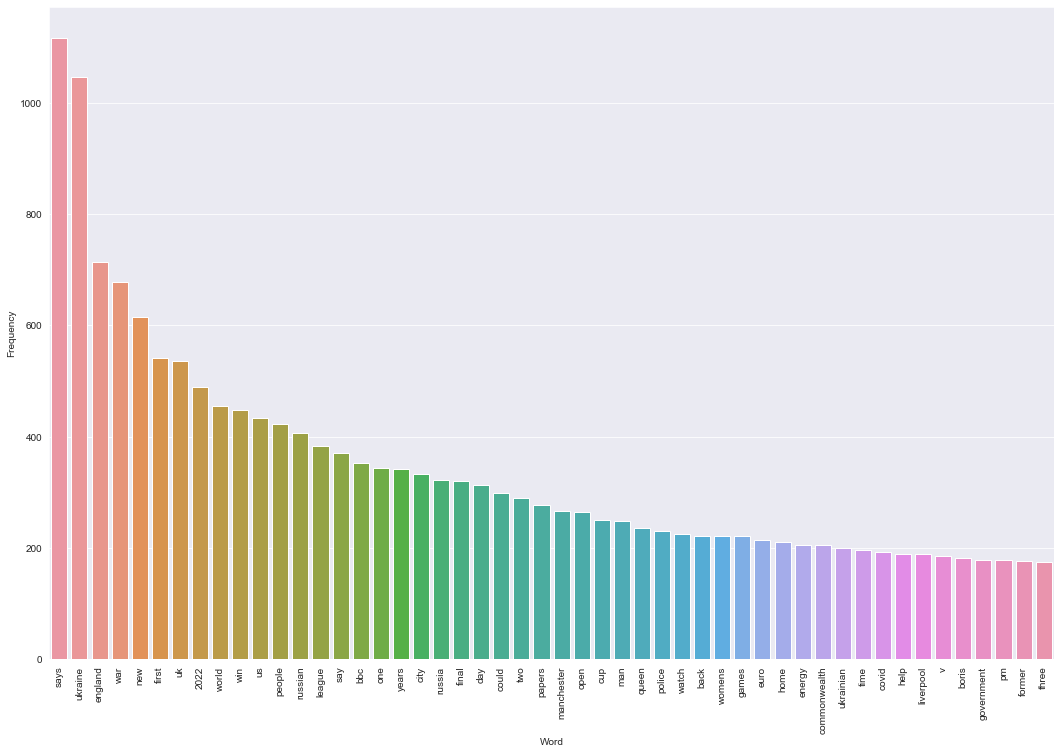

In [13]:
plt.figure(figsize=(18, 12))
sns.barplot(data=freq_title, x='Word', y='Frequency')
plt.xticks(rotation=90)

## Looking for the most popular 2-grams and 3-grams

In [14]:
def find_ngrams(input_list, n):
    return list(zip(*(input_list[i:] for i in range(n))))

In [15]:
bigrams = find_ngrams(words, 2)
bigrams

[('ukraine', 'angry'),
 ('angry', 'zelensky'),
 ('zelensky', 'vows'),
 ('vows', 'punish'),
 ('punish', 'russian'),
 ('russian', 'atrocities'),
 ('atrocities', 'ukrainian'),
 ('ukrainian', 'president'),
 ('president', 'says'),
 ('says', 'country'),
 ('country', 'forgive'),
 ('forgive', 'forget'),
 ('forget', 'murder'),
 ('murder', 'civilians'),
 ('civilians', 'war'),
 ('war', 'ukraine'),
 ('ukraine', 'taking'),
 ('taking', 'cover'),
 ('cover', 'town'),
 ('town', 'attack'),
 ('attack', 'jeremy'),
 ('jeremy', 'bowen'),
 ('bowen', 'frontline'),
 ('frontline', 'irpin'),
 ('irpin', 'residents'),
 ('residents', 'came'),
 ('came', 'russian'),
 ('russian', 'fire'),
 ('fire', 'trying'),
 ('trying', 'flee'),
 ('flee', 'ukraine'),
 ('ukraine', 'war'),
 ('war', 'catastrophic'),
 ('catastrophic', 'global'),
 ('global', 'food'),
 ('food', 'one'),
 ('one', 'worlds'),
 ('worlds', 'biggest'),
 ('biggest', 'fertiliser'),
 ('fertiliser', 'firms'),
 ('firms', 'says'),
 ('says', 'conflict'),
 ('conflict', '

In [16]:
bigrams_dist = nltk.FreqDist(bigrams)
bigram_freq_title = pd.DataFrame(bigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
bigram_freq_title

,N-gram,Frequency
0,"(ukraine, war)",358
1,"(euro, 2022)",206
2,"(commonwealth, games)",170
3,"(world, cup)",151
4,"(boris, johnson)",143
5,"(premier, league)",128
6,"(champions, league)",120
7,"(cost, living)",116
8,"(south, africa)",110
9,"(manchester, city)",109


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, "('ukraine', 'war')"),
  Text(1, 0, "('euro', '2022')"),
  Text(2, 0, "('commonwealth', 'games')"),
  Text(3, 0, "('world', 'cup')"),
  Text(4, 0, "('boris', 'johnson')"),
  Text(5, 0, "('premier', 'league')"),
  Text(6, 0, "('champions', 'league')"),
  Text(7, 0, "('cost', 'living')"),
  Text(8, 0, "('south', 'africa')"),
  Text(9, 0, "('manchester', 'city')"),
  Text(10, 0, "('war', 'ukraine')"),
  Text(11, 0, "('england', 'v')"),
  Text(12, 0, "('liz', 'truss')"),
  Text(13, 0, "('manchester', 'united')"),
  Text(14, 0, "('queen', 'elizabeth')"),
  Text(15, 0, "('new', 'zealand')"),
  Text(16, 0, "('us', 'open')"),
  Text(17, 0, "('first', 'time')"),
  Text(18, 0, "('prime', 'minister')"),
  Text(19, 0, "('tory', 'leadership')"),
  Text(20, 0, "('n

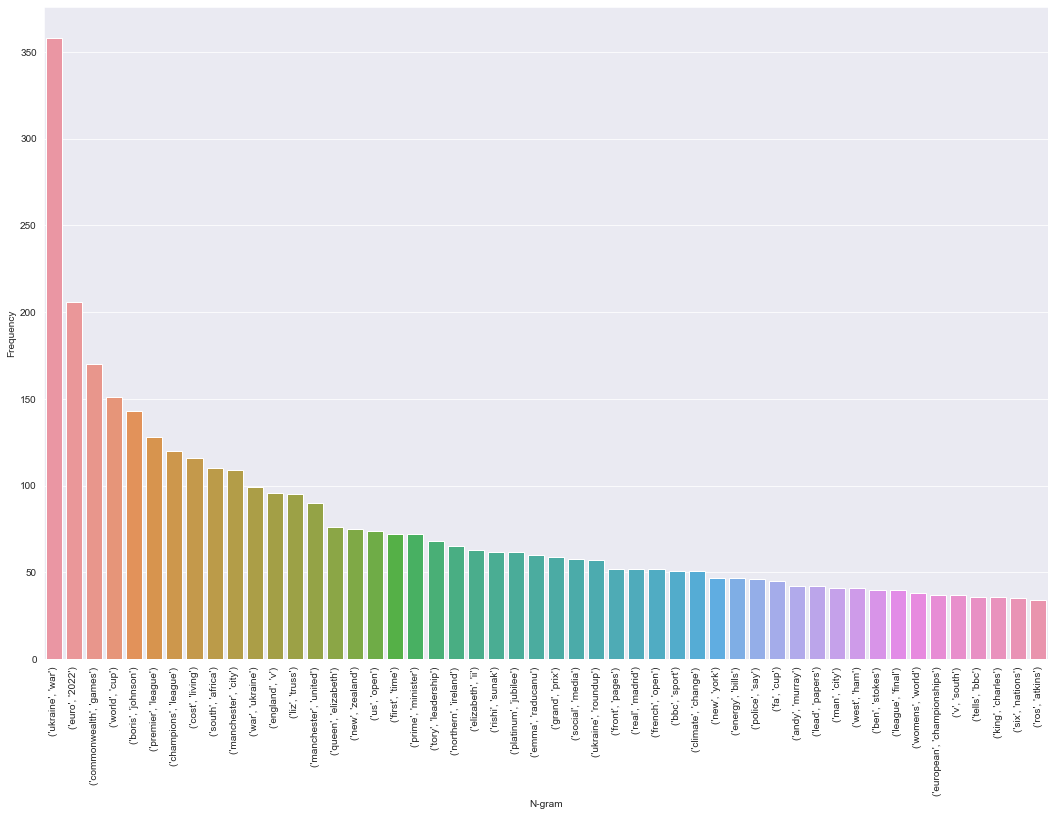

In [17]:
plt.figure(figsize=(18, 12))
sns.barplot(data=bigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

In [18]:
trigrams = find_ngrams(words, 3)
trigrams

[('ukraine', 'angry', 'zelensky'),
 ('angry', 'zelensky', 'vows'),
 ('zelensky', 'vows', 'punish'),
 ('vows', 'punish', 'russian'),
 ('punish', 'russian', 'atrocities'),
 ('russian', 'atrocities', 'ukrainian'),
 ('atrocities', 'ukrainian', 'president'),
 ('ukrainian', 'president', 'says'),
 ('president', 'says', 'country'),
 ('says', 'country', 'forgive'),
 ('country', 'forgive', 'forget'),
 ('forgive', 'forget', 'murder'),
 ('forget', 'murder', 'civilians'),
 ('murder', 'civilians', 'war'),
 ('civilians', 'war', 'ukraine'),
 ('war', 'ukraine', 'taking'),
 ('ukraine', 'taking', 'cover'),
 ('taking', 'cover', 'town'),
 ('cover', 'town', 'attack'),
 ('town', 'attack', 'jeremy'),
 ('attack', 'jeremy', 'bowen'),
 ('jeremy', 'bowen', 'frontline'),
 ('bowen', 'frontline', 'irpin'),
 ('frontline', 'irpin', 'residents'),
 ('irpin', 'residents', 'came'),
 ('residents', 'came', 'russian'),
 ('came', 'russian', 'fire'),
 ('russian', 'fire', 'trying'),
 ('fire', 'trying', 'flee'),
 ('trying', 'fle

In [19]:
trigrams_dist = nltk.FreqDist(trigrams)
trigram_freq_title = pd.DataFrame(trigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
trigram_freq_title

,N-gram,Frequency
0,"(queen, elizabeth, ii)",61
1,"(womens, world, cup)",37
2,"(v, south, africa)",37
3,"(england, v, south)",36
4,"(england, v, new)",29
5,"(v, new, zealand)",29
6,"(champions, league, final)",28
7,"(cost, living, crisis)",27
8,"(world, snooker, championship)",26
9,"(commonwealth, games, birmingham)",25


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, "('queen', 'elizabeth', 'ii')"),
  Text(1, 0, "('womens', 'world', 'cup')"),
  Text(2, 0, "('v', 'south', 'africa')"),
  Text(3, 0, "('england', 'v', 'south')"),
  Text(4, 0, "('england', 'v', 'new')"),
  Text(5, 0, "('v', 'new', 'zealand')"),
  Text(6, 0, "('champions', 'league', 'final')"),
  Text(7, 0, "('cost', 'living', 'crisis')"),
  Text(8, 0, "('world', 'snooker', 'championship')"),
  Text(9, 0, "('commonwealth', 'games', 'birmingham')"),
  Text(10, 0, "('roe', 'v', 'wade')"),
  Text(11, 0, "('2022', 'commonwealth', 'games')"),
  Text(12, 0, "('euro', '2022', 'final')"),
  Text(13, 0, "('england', 'v', 'india')"),
  Text(14, 0, "('king', 'charles', 'iii')"),
  Text(15, 0, "('ukraine', 'war', 'russia')"),
  Text(16, 0, "('commonwealth', 'games'

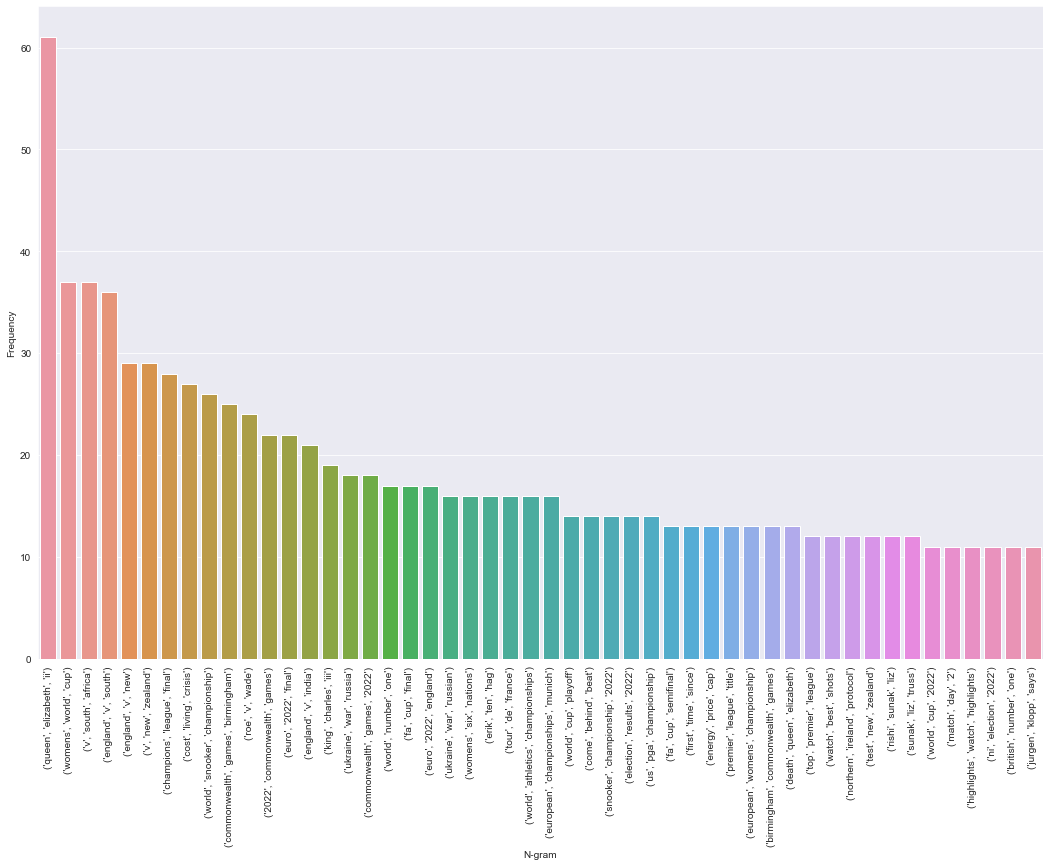

In [20]:
plt.figure(figsize=(18, 12))
sns.barplot(data=trigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

# Cleaning data (removing punctuation)

In [21]:
# lower and remove punctuation
data['combined_cleaned'] = data['combined'].str.lower().apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]', '', x))
data

,title,pubDate,guid,link,description,combined,combined_cleaned
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56+00:00,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,Ukraine: Angry Zelensky vows to punish Russian...,ukraine angry zelensky vows to punish russian ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58+00:00,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",War in Ukraine: Taking cover in a town under a...,war in ukraine taking cover in a town under at...
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42+00:00,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,Ukraine war 'catastrophic for global food' One...,ukraine war catastrophic for global food one o...
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40+00:00,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,Manchester Arena bombing: Saffie Roussos's par...,manchester arena bombing saffie roussoss paren...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53+00:00,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,Ukraine conflict: Oil price soars to highest l...,ukraine conflict oil price soars to highest le...
...,...,...,...,...,...,...,...
7359,Premiership: Harlequins 27-30 Saracens - Sarri...,2022-09-17 18:07:42+00:00,https://www.bbc.co.uk/sport/rugby-union/62927697,https://www.bbc.co.uk/sport/rugby-union/629276...,Saracens battle back from 17-0 down to beat Ha...,Premiership: Harlequins 27-30 Saracens - Sarri...,premiership harlequins 2730 saracens sarries ...
7360,The queue - and the expert who helped plan it,2022-09-17 06:35:24+00:00,https://www.bbc.co.uk/news/uk-england-cumbria-...,https://www.bbc.co.uk/news/uk-england-cumbria-...,Thousands of people have lined up for miles to...,The queue - and the expert who helped plan it ...,the queue and the expert who helped plan it t...
7361,The cowboy and the Queen who bonded over horses,2022-09-16 23:01:06+00:00,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...,The cowboy and the Queen who bonded over horse...,the cowboy and the queen who bonded over horse...
7362,Queen amused by an American's breach of protocol,2022-09-16 14:52:59+00:00,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...,Queen amused by an American's breach of protoc...,queen amused by an americans breach of protoco...


In [22]:
# remove redundant spaces
data['combined_cleaned'] = data['combined_cleaned'].str.strip()
data

,title,pubDate,guid,link,description,combined,combined_cleaned
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56+00:00,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,Ukraine: Angry Zelensky vows to punish Russian...,ukraine angry zelensky vows to punish russian ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58+00:00,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",War in Ukraine: Taking cover in a town under a...,war in ukraine taking cover in a town under at...
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42+00:00,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,Ukraine war 'catastrophic for global food' One...,ukraine war catastrophic for global food one o...
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40+00:00,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,Manchester Arena bombing: Saffie Roussos's par...,manchester arena bombing saffie roussoss paren...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53+00:00,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,Ukraine conflict: Oil price soars to highest l...,ukraine conflict oil price soars to highest le...
...,...,...,...,...,...,...,...
7359,Premiership: Harlequins 27-30 Saracens - Sarri...,2022-09-17 18:07:42+00:00,https://www.bbc.co.uk/sport/rugby-union/62927697,https://www.bbc.co.uk/sport/rugby-union/629276...,Saracens battle back from 17-0 down to beat Ha...,Premiership: Harlequins 27-30 Saracens - Sarri...,premiership harlequins 2730 saracens sarries ...
7360,The queue - and the expert who helped plan it,2022-09-17 06:35:24+00:00,https://www.bbc.co.uk/news/uk-england-cumbria-...,https://www.bbc.co.uk/news/uk-england-cumbria-...,Thousands of people have lined up for miles to...,The queue - and the expert who helped plan it ...,the queue and the expert who helped plan it t...
7361,The cowboy and the Queen who bonded over horses,2022-09-16 23:01:06+00:00,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...,The cowboy and the Queen who bonded over horse...,the cowboy and the queen who bonded over horse...
7362,Queen amused by an American's breach of protocol,2022-09-16 14:52:59+00:00,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...,Queen amused by an American's breach of protoc...,queen amused by an americans breach of protoco...


In [23]:
data['combined_cleaned'][0], data['combined_cleaned'][1]

('ukraine angry zelensky vows to punish russian atrocities the ukrainian president says the country will not forgive or forget those who murder its civilians',
 'war in ukraine taking cover in a town under attack jeremy bowen was on the frontline in irpin as residents came under russian fire while trying to flee')

In [24]:
data['combined_cleaned'].apply(len).describe()

count    7364.000000
mean      163.937806
std        29.922657
min        70.000000
25%       146.000000
50%       156.000000
75%       172.000000
max       321.000000
Name: combined_cleaned, dtype: float64

# Lemmatization

In [25]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('civilians')

'civilian'

In [26]:
data['combined_cleaned']=data['combined_cleaned'].apply(lambda x: ' '.join(map(lemmatizer.lemmatize, filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(x)))))
data['combined'][100], data['combined_cleaned'][100]

('Cost of living: Warning UK faces biggest income squeeze in nearly 50 years The war in Ukraine will lead to an even tighter squeeze on living standards this spring, a think tank says.',
 'cost living warning uk face biggest income squeeze nearly 50 year war ukraine lead even tighter squeeze living standard spring think tank say')

## Normalizing data

In [27]:
cv = CountVectorizer(analyzer='word')
cv_data = cv.fit_transform(data['combined_cleaned'])
dtm_data = pd.DataFrame(cv_data.toarray(), columns=cv.get_feature_names_out())
dtm_data.index = data.index
dtm_data.head(5)

,00,007,008,01,0100,02,03,03mm,04,05,...,zookeepers,zoom,zsl,zuckerberg,zulu,zurich,zuu,zverev,zwelithini,úsuga
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Wordclouds

In [99]:
# Function for generating word clouds
def generate_wordcloud(data, title, bg='white', colormap='Dark2', mask=None):
    wc = WordCloud(width=1600, height=1080, max_words=150, colormap=colormap, mask=mask, background_color=bg).generate_from_frequencies(data)
    plt.figure(figsize=(16,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('\n'.join(wrap(title,60)),fontsize=26)
    plt.show()

In [100]:
ASSETS_PATH = './assets'

In [101]:
f100_mask = np.array(Image.open(ASSETS_PATH + '/100.png'))

In [102]:
latest100indexes = data.sort_values(by=['pubDate'], ascending=False).index

## Latest 100 titles

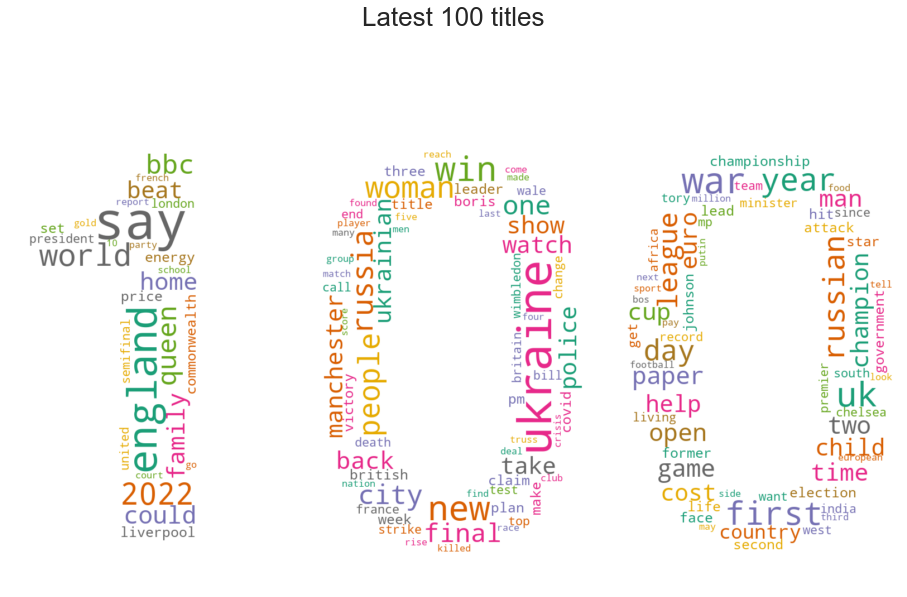

In [103]:
generate_wordcloud(dtm_data.loc[latest100indexes].T.sum(axis=1), 'Latest 100 titles', mask=f100_mask)

## Latest 500 titles

In [104]:
f500_mask = np.array(Image.open(ASSETS_PATH + '/500.png'))

In [105]:
latest500indexes = data.sort_values(by=['pubDate'], ascending=False).index

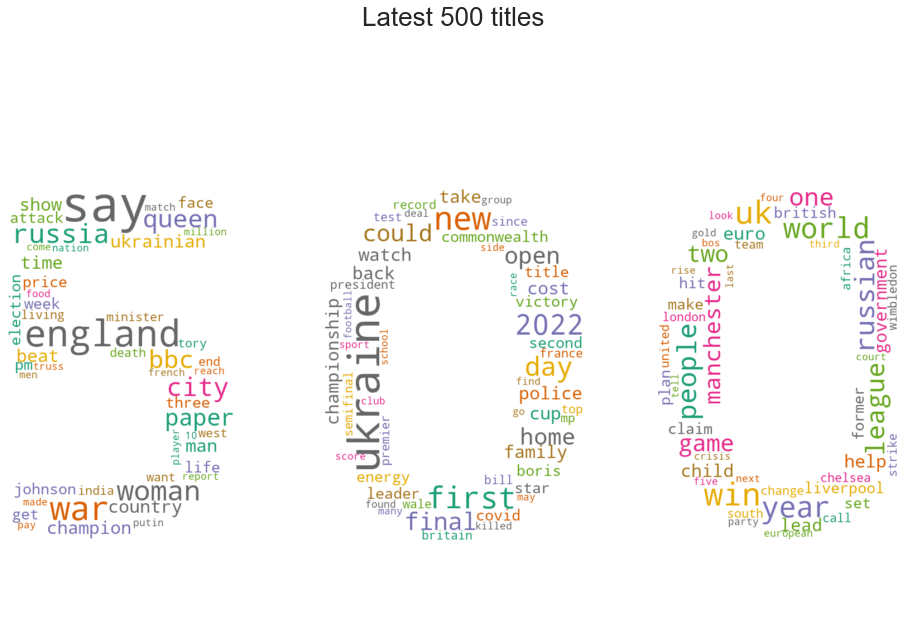

In [106]:
generate_wordcloud(dtm_data.loc[latest500indexes].T.sum(axis=1), 'Latest 500 titles', mask=f500_mask)

In [36]:
data['combined_polarity']=data['combined_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
data

,title,pubDate,guid,link,description,combined,combined_cleaned,combined_polarity
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56+00:00,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,Ukraine: Angry Zelensky vows to punish Russian...,ukraine angry zelensky vow punish russian atro...,-0.250000
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58+00:00,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",War in Ukraine: Taking cover in a town under a...,war ukraine taking cover town attack jeremy bo...,0.000000
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42+00:00,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,Ukraine war 'catastrophic for global food' One...,ukraine war catastrophic global food one world...,-0.100000
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40+00:00,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,Manchester Arena bombing: Saffie Roussos's par...,manchester arena bombing saffie roussoss paren...,-0.075000
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53+00:00,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,Ukraine conflict: Oil price soars to highest l...,ukraine conflict oil price soar highest level ...,0.250000
...,...,...,...,...,...,...,...,...
7359,Premiership: Harlequins 27-30 Saracens - Sarri...,2022-09-17 18:07:42+00:00,https://www.bbc.co.uk/sport/rugby-union/62927697,https://www.bbc.co.uk/sport/rugby-union/629276...,Saracens battle back from 17-0 down to beat Ha...,Premiership: Harlequins 27-30 Saracens - Sarri...,premiership harlequin 2730 saracen sarries win...,0.154167
7360,The queue - and the expert who helped plan it,2022-09-17 06:35:24+00:00,https://www.bbc.co.uk/news/uk-england-cumbria-...,https://www.bbc.co.uk/news/uk-england-cumbria-...,Thousands of people have lined up for miles to...,The queue - and the expert who helped plan it ...,queue expert helped plan thousand people lined...,0.000000
7361,The cowboy and the Queen who bonded over horses,2022-09-16 23:01:06+00:00,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...,The cowboy and the Queen who bonded over horse...,cowboy queen bonded horse sitting head state m...,0.000000
7362,Queen amused by an American's breach of protocol,2022-09-16 14:52:59+00:00,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...,Queen amused by an American's breach of protoc...,queen amused american breach protocol monarch ...,0.475000


In [37]:
data.describe()

,combined_polarity
count,7364.000000
mean,0.054711
std,0.239993
min,-1.000000
25%,-0.013571
50%,0.000000
75%,0.160000
max,1.000000


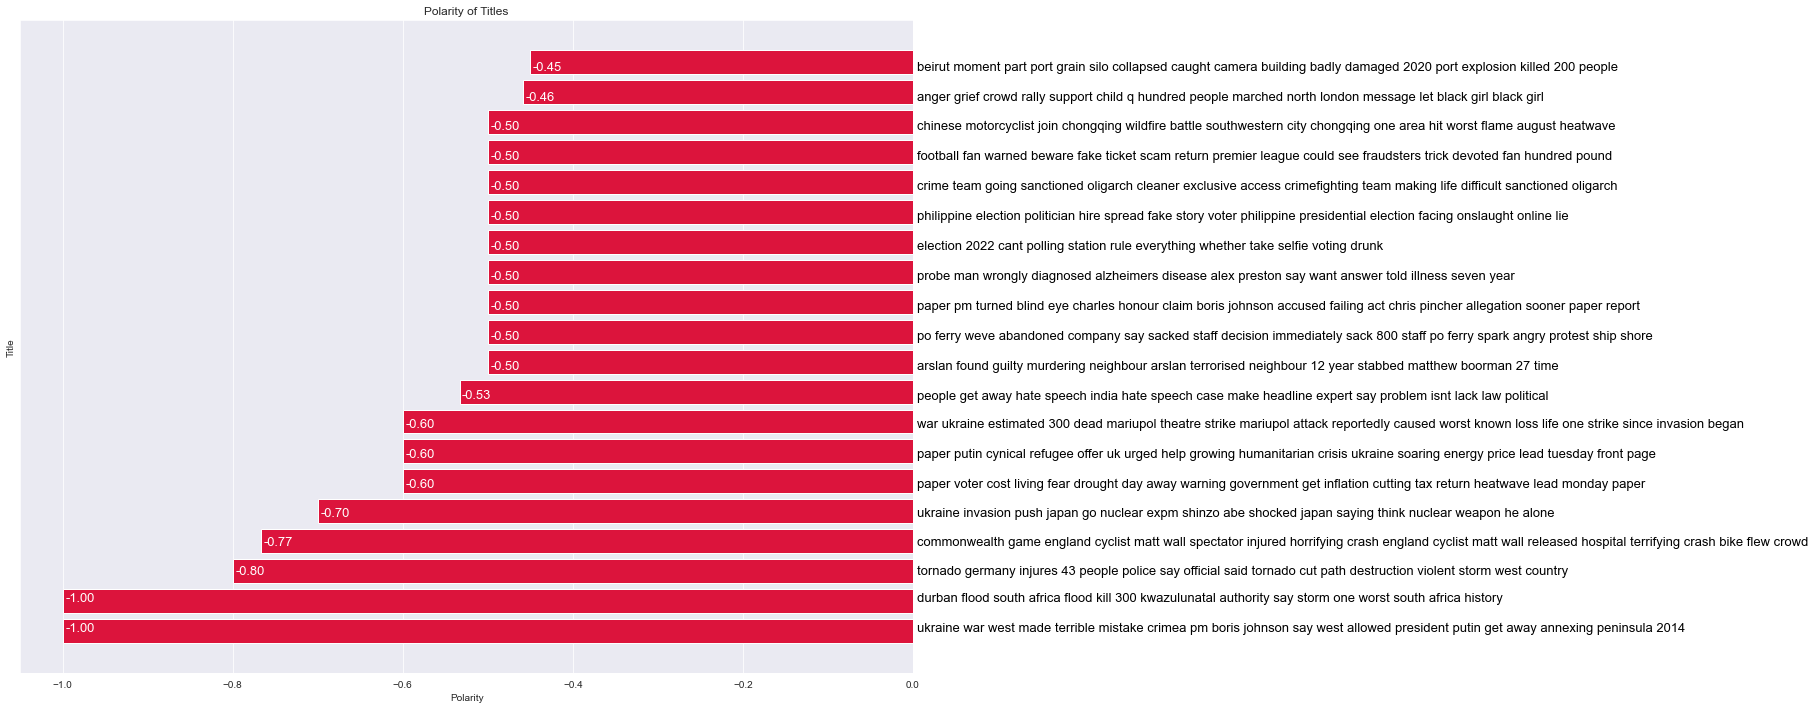

In [108]:
title_polarity_sorted = data['combined_polarity'].sort_values(ascending=True).copy()[:200:10]

plt.figure(figsize=(16,12))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Titles')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='crimson')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() - bar.get_width() / 2, str(data['combined_cleaned'][polarity_idx]), va='center', fontsize=13, color='black')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() - bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='white')

plt.yticks([])
plt.show()

In [109]:
title_polarity_sorted

369    -1.000000
1548   -1.000000
2933   -0.800000
5578   -0.766667
839    -0.700000
5881   -0.600000
110    -0.600000
773    -0.600000
1576   -0.533333
1203   -0.500000
520    -0.500000
4477   -0.500000
2726   -0.500000
2307   -0.500000
2420   -0.500000
3133   -0.500000
5670   -0.500000
6909   -0.500000
627    -0.458333
5587   -0.450000
Name: combined_polarity, dtype: float64

In [110]:
thumb_down_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png').transpose(method=Image.FLIP_TOP_BOTTOM))
thumb_down_mask-=1
thumb_down_mask[thumb_down_mask == 0] = 255

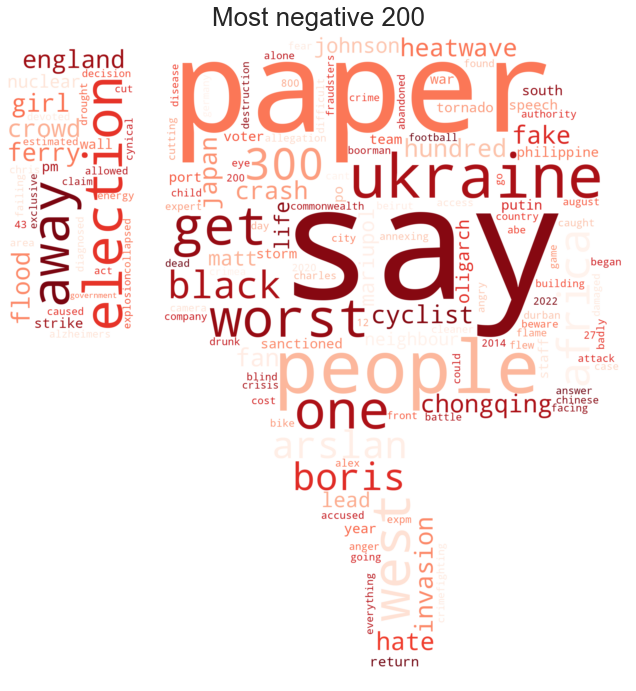

In [111]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most negative 200', colormap='Reds', mask=thumb_down_mask)

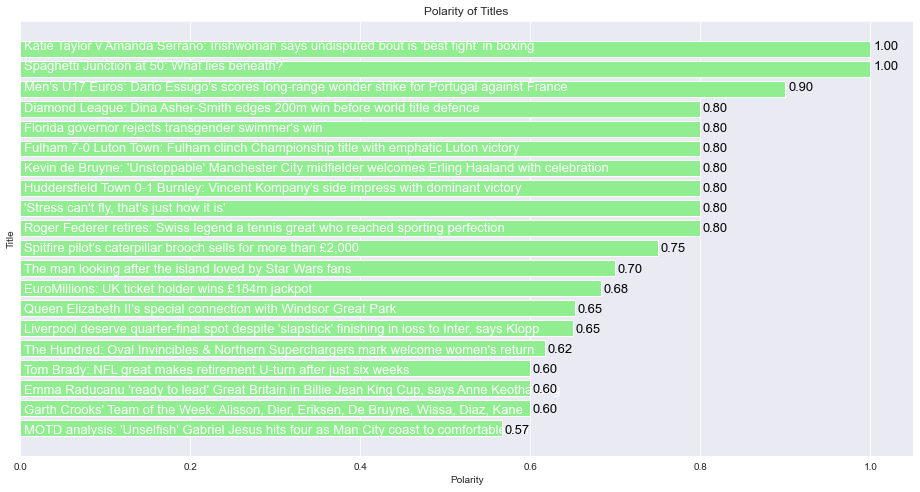

In [112]:
title_polarity_sorted = data['combined_polarity'].sort_values(ascending=True).copy()[-200::10]

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Titles')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='lightgreen')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() + bar.get_width() / 2, str(data['title'][polarity_idx]), va='center', fontsize=13, color='white')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() + bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='black')
    
plt.yticks([])
plt.show()

In [113]:
thumb_up_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png'))
thumb_up_mask-=1
thumb_up_mask[thumb_up_mask == 0] = 255

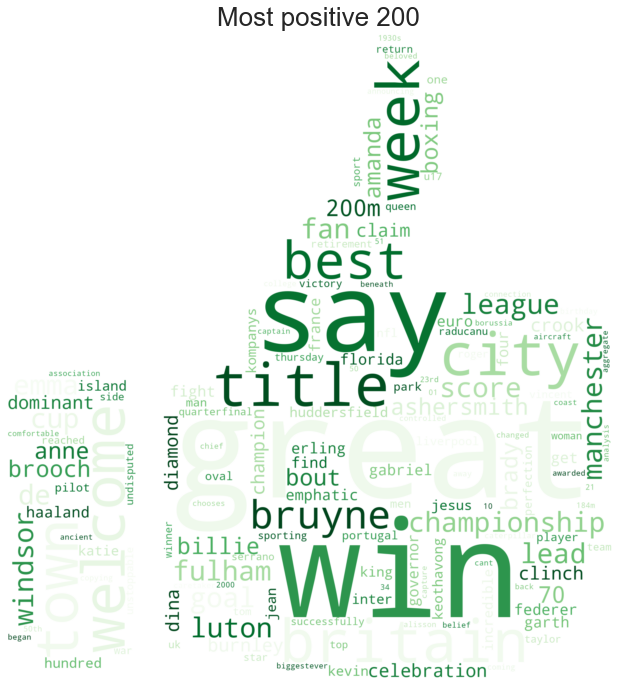

In [114]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most positive 200', colormap='Greens', mask=thumb_up_mask)